In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import cv2


In [2]:
# Paths
train_dir = r"C:\Users\USER\OneDrive\Desktop\sande\trainimages"
test_dir = r"C:\Users\USER\OneDrive\Desktop\sande\testimages"


In [3]:
# Parameters
img_size = (224, 224)  # Using 224x224 for compatibility with ResNet50
batch_size = 32


In [4]:
# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 4171 images belonging to 5 classes.
Found 838 images belonging to 5 classes.


In [5]:
# Map class indices
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

Classes: ['Alternaria', 'Anthracnose', 'Aspergillus', 'Healthy', 'Lasiodiplodia']


In [6]:
# Model: Transfer Learning with ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_names), activation='softmax')(x)

cnn_model = Model(inputs=base_model.input, outputs=output_layer)
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Train CNN
history = cnn_model.fit(train_generator, epochs=15, validation_data=test_generator)


c:\Users\USER\OneDrive\Desktop\sande\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.2135 - loss: 1.8493 - val_accuracy: 0.2446 - val_loss: 1.5954
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.2192 - loss: 1.6472 - val_accuracy: 0.2721 - val_loss: 1.5929
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.2291 - loss: 1.6110 - val_accuracy: 0.2470 - val_loss: 1.5876
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.2372 - loss: 1.5988 - val_accuracy: 0.2458 - val_loss: 1.5866
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.2396 - loss: 1.5882 - val_accuracy: 0.2446 - val_loss: 1.5828
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.2477 - loss: 1.5917 - val_accuracy: 0.2446 - val_loss: 1.5817
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.2440 - loss: 1.5918 - val_accuracy: 0.2458 - val_loss: 1.5779
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.2442 - loss: 1.5835 - val_accu

In [9]:
# Fine-tune base model
for layer in base_model.layers:
    layer.trainable = True

cnn_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = cnn_model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 962s 7s/step - accuracy: 0.2842 - loss: 3.7276 - val_accuracy: 0.1718 - val_loss: 4.2115
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 885s 7s/step - accuracy: 0.6607 - loss: 0.8551 - val_accuracy: 0.3294 - val_loss: 3.5958
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 840s 6s/step - accuracy: 0.7902 - loss: 0.5593 - val_accuracy: 0.2625 - val_loss: 3.5887
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 795s 6s/step - accuracy: 0.8468 - loss: 0.4276 - val_accuracy: 0.3007 - val_loss: 3.3570
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 779s 6s/step - accuracy: 0.8721 - loss: 0.3504 - val_accuracy: 0.3914 - val_loss: 2.2454
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 779s 6s/step - accuracy: 0.9047 - loss: 0.2783 - val_accuracy: 0.6754 - val_loss: 0.9943
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 797s 6s/step - accuracy: 0.9289 - loss: 0.2174 - val_accuracy: 0.8866 - val_loss: 0.3398
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 841s 6s/step - accuracy: 0.9364 - loss: 0.1952 - val_accu

In [10]:
# Evaluate CNN
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy (CNN): {test_acc:.2f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9764 - loss: 0.0738
Test Accuracy (CNN): 0.98


In [11]:
# Save CNN model
cnn_model.save("optimized_cnn_model.h5")


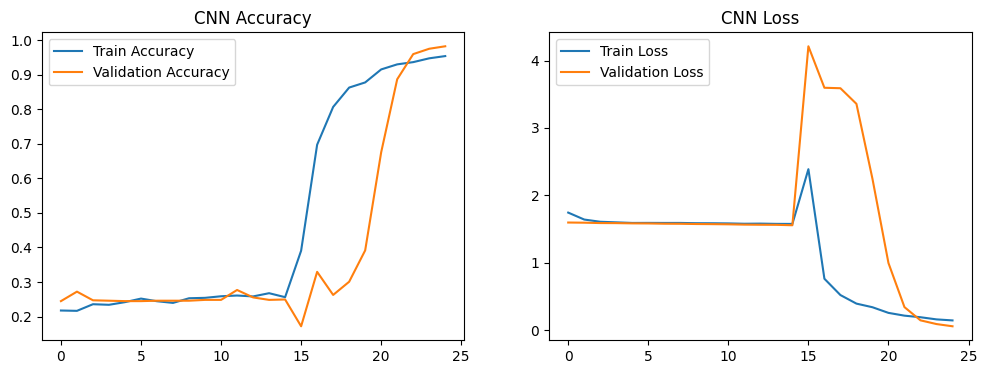

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.legend()
plt.show()


In [13]:
# Extract features for SVM
def extract_features(generator, model):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)
        if len(features) * batch_size >= len(generator.filenames):
            break
    return np.vstack(features), np.argmax(np.vstack(labels), axis=1)

train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [14]:
# SVM Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='accuracy')
grid.fit(train_features, train_labels)


GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [15]:
# Best SVM model
svm = grid.best_estimator_
print(f"Best SVM Parameters: {grid.best_params_}")


Best SVM Parameters: {'C': 10, 'kernel': 'rbf'}


In [16]:
# Evaluate SVM
svm_predictions = svm.predict(test_features)
print("Classification Report (SVM):\n", classification_report(test_labels, svm_predictions, target_names=class_names))


Classification Report (SVM):
                precision    recall  f1-score   support

   Alternaria       0.98      0.96      0.97       165
  Anthracnose       0.98      0.96      0.97       129
  Aspergillus       0.97      0.98      0.98       182
      Healthy       1.00      1.00      1.00       205
Lasiodiplodia       0.98      1.00      0.99       157

     accuracy                           0.98       838
    macro avg       0.98      0.98      0.98       838
 weighted avg       0.98      0.98      0.98       838



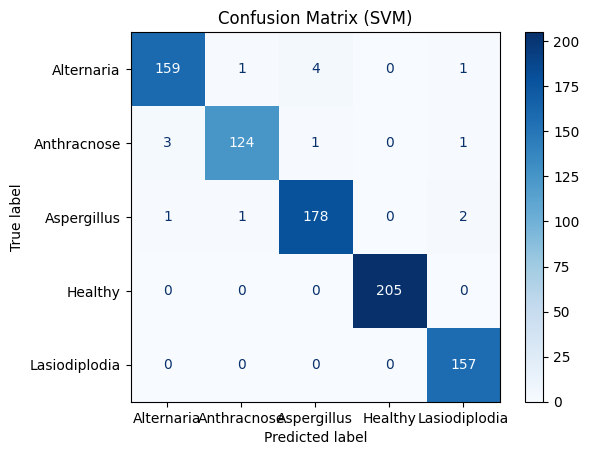

In [17]:
# Confusion Matrix
cm = confusion_matrix(test_labels, svm_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (SVM)')
plt.show()

In [18]:
# Predictions on test images
sample_images = test_generator.filepaths[:5]
for img_path in sample_images:
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, img_size) / 255.0
    img_array = np.expand_dims(img_resized, axis=0)
    cnn_pred = cnn_model.predict(img_array)
    svm_pred = svm.predict(cnn_model.predict(img_array))
    print(f"Image: {os.path.basename(img_path)}")
    print(f"Predicted (CNN): {class_names[np.argmax(cnn_pred)]}")
    print(f"Predicted (SVM): {class_names[svm_pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Image: Alternaria_005.jpg
Predicted (CNN): Alternaria
Predicted (SVM): Alternaria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image: Alternaria_006.jpg
Predicted (CNN): Alternaria
Predicted (SVM): Alternaria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Image: Alternaria_007.jpg
Predicted (CNN): Anthracnose
Predicted (SVM): Anthracnose
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Image: Alternaria_008.jpg
Predicted (CNN): Anthracnose
Predicted (SVM): Anthracnose
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Image: Alternaria_009.jpg
Predicted (CNN): Anthracnose
Predicted (SVM): Anthracnose


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


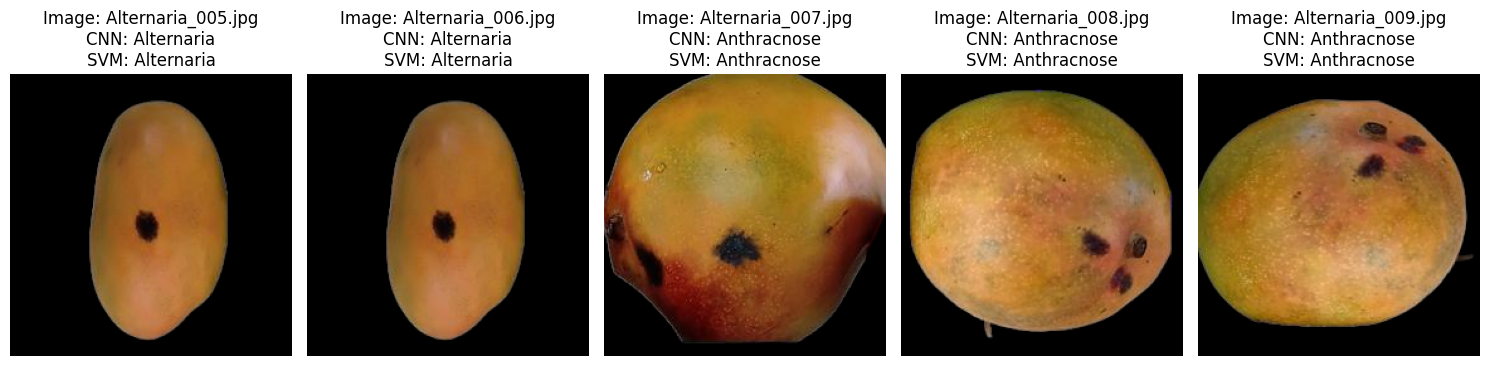

In [19]:
import matplotlib.pyplot as plt
import cv2

# Predictions on test images with visualization
sample_images = test_generator.filepaths[:5]  # Taking first 5 test images
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_images):
    # Read and preprocess the image
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, img_size) / 255.0
    img_array = np.expand_dims(img_resized, axis=0)
    
    # Predictions
    cnn_pred = cnn_model.predict(img_array)
    svm_pred = svm.predict(cnn_model.predict(img_array))
    
    # Display image with predictions
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(img_path)}\n"
              f"CNN: {class_names[np.argmax(cnn_pred)]}\n"
              f"SVM: {class_names[svm_pred[0]]}")

plt.tight_layout()
plt.show()
